# Face Recognition Lab

In [1]:
import math
import time

import cv2
from matplotlib import pyplot as plt
import mxnet as mx
from mxnet import autograd, gluon
import numpy as np
from gluoncv.utils import download, viz
import gluoncv as gcv
import gluonfr as gfr

## Face Detector

We load a pre-trained face detector: https://github.com/YYuanAnyVision/mxnet_mtcnn_face_detection


In [2]:
from mtcnn_detector import MtcnnDetector

In [3]:
detector = MtcnnDetector(model_folder='model')

In [344]:
imgs_small = [mx.image.resize_short(mx.image.imread(filepath), 200).asnumpy() for filepath in 
            ['../friends.jpg', '../friends1.jpg', '../friends4.jpg', '../friends2.jpg']]
imgs_large = [mx.image.imread(filepath).asnumpy() for filepath in 
            ['../friends.jpg', '../friends1.jpg', '../friends4.jpg', '../friends2.jpg']]

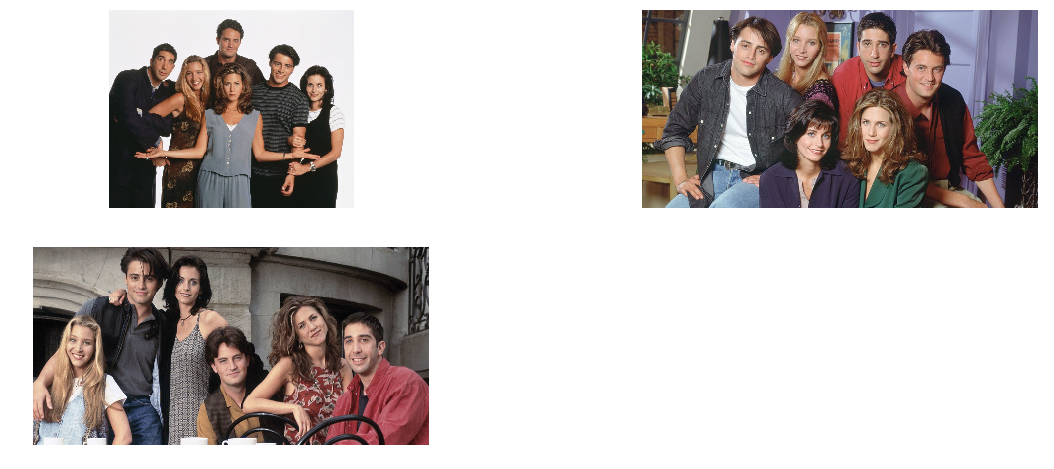

In [305]:
fig=plt.figure(figsize=(20, 8))
columns = 2
rows = 2
for i in range(1, columns*rows +1):
    if i > len(imgs_small):
        break
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(imgs_small[i-1])
plt.show()

In [345]:
chips = []
for i, img in enumerate(imgs_small):
    out =detector.detect_face(img)
    if out is None:
        continue
    for points in out[1]:
        for k in range(5):
            points[k] /= (img.shape[1]/imgs_large[i].shape[1])
            points[k+5] /= (img.shape[0]/imgs_large[i].shape[0])
    chips += detector.extract_image_chips(imgs_large[i], out[1], desired_size=112, padding=0.1)

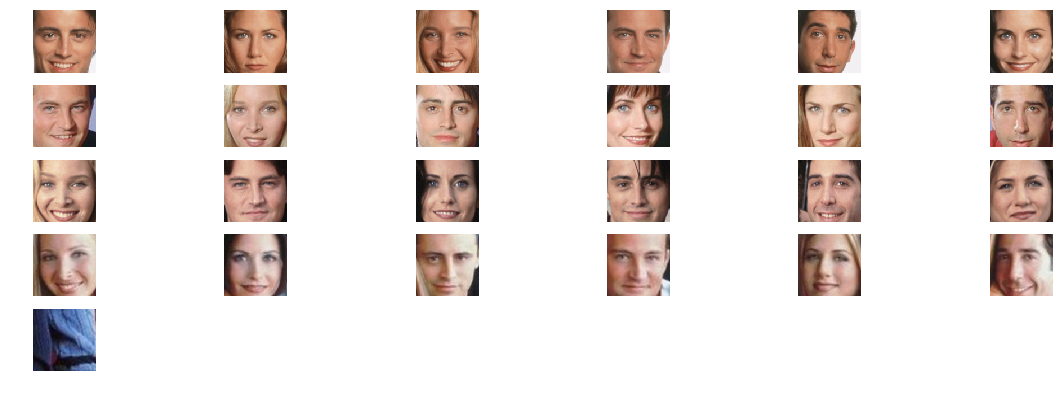

In [346]:
fig=plt.figure(figsize=(20, 8))
columns = 6
rows = 6
for i in range(1, columns*rows +1):
    if i > len(chips):
        break
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(chips[i-1])
plt.show()

# Face Recognition

In [308]:
import gluonfr as gfr

### Loading Model

In [309]:
net = gfr.model_zoo.get_mobile_facenet(need_cls_layer=False)

In [310]:
net.load_parameters('model/mobilefacenet.params')

### Getting Features

In [311]:
transform = gluon.data.vision.transforms.ToTensor()

In [347]:
features = []
for chip in chips:
    data = transform(mx.nd.array(chip).expand_dims(axis=0))
    feature = net(data).asnumpy()[0]
    feature /= math.sqrt((feature*feature).sum())
    features.append(feature)

### Comparing distances

In [348]:
def l2_distance(x,y):
    return math.sqrt(((x-y)*(x-y)).sum())

def cosine_distance(x,y):
    return 1-abs(np.dot(x,y.T)/(np.sqrt((x*x).sum())*np.sqrt((y*y).sum())))

distance_function = cosine_distance

In [349]:
n = len(features)
distances = np.zeros((n,n))
for i in range(n):
    for j in range(i, n):
        distance = distance_function(features[i], features[j])
        distances[i,j] = distance
        distances[j,i] = distance
    

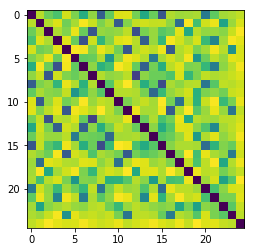

In [350]:
plt.imshow(distances)

# Show matches

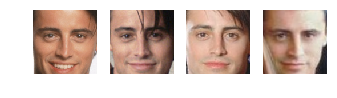

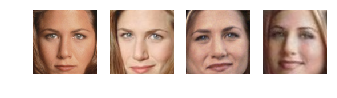

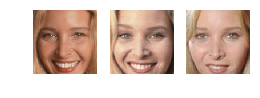

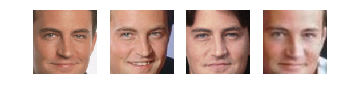

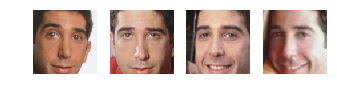

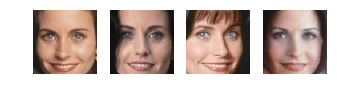

In [363]:
threshold = 0.6
for i, chip in enumerate(chips[:6]):
    distance = distances[i]
    top_picks = distance.argsort()
    fig=plt.figure(figsize=(8, 8))
    columns = 6
    for j, pick in enumerate(top_picks):
        if j > columns or distance[pick] > threshold:
            break
        fig.add_subplot(1, columns, j+1)
        plt.axis('off')
        plt.imshow(chips[pick])
    plt.show()